***
# 15-288 Final Project

## A Query Answering Machine that Predicts the Country from Images

### By Salman Hajizada, Abdulrahman Al-Taweel, Ravin Kumar
***

## <font color = 'skyblue' size = 5>  **Goal: To classify images of 18 popular cities by country** </font>

<font color = 'steelblue' size = 3> **We will first do some simple setup before getting to the dataset** </font>

<font color = 'steelblue' size = 3> **We use a variable to seamlessly determine filepaths when switching between running the script on kaggle and running on local machines** </font>

In [7]:
# whether notebook is running on kaggle or not 
KAGGLE = False

<font color = 'steelblue' size = 3> **Make sure that tensorflow is using GPUs for training if using kaggle** </font>

In [3]:
if KAGGLE:
    import tensorflow as tf
    tf.config.list_physical_devices('GPU')

2024-04-25 22:32:41.612547: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 22:32:41.612666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 22:32:41.738297: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

 <font color = 'skyblue' size = 5> **Import all the modules that will be needed** </font>

In [8]:
import os
import skimage
import cv2
from skimage import util,filters
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import re
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Flatten, MaxPool2D, Input

# <font color = 'blue' size = 6>  **Dataset** </font>

 ## <font color = 'skyblue' size = 5>  **2.1 Data Collection** </font>

<font color = 'steelblue' size = 3> **The data was scraped from Google images using the python scripts `image_scraper.py` and `image_downloader.py`** </font>

<font color = 'steelblue' size = 3> **The images are then cropped if they have banners with a website name at the bottom of them as some websites put a solid colour banner on images from their site.** </font>

In [3]:

def crop_and_save(filepath: str):
    """crops an image to get rid of a website banner at the bottom of the image 
       if it contains one and saves it at the filepath provided

    Args:
        filepath (str): the filepath of the image
    """

    # read the image
    image = cv2.imread(filepath)
    try:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    except:
        try:
            image = image.astype(np.uint8)
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        except Exception as e:
            print(f'failed to crop {filepath} with error\n{e}')
            return
        
    height = gray_image.shape[-2]

    # if the image does not have a banner then ignore it
    if abs(int(gray_image[height - 1, 0]) - int(gray_image[height-11, 0])) > 15:
        return

    # go from bottom and find the first row from bottom that has a significant color change
    change_row = height - 1
    for row in range(height - 1, -1, -1):
        if abs(int(gray_image[row, 0]) - int(gray_image[height - 1, 0])) > 15:
            change_row = row
            break

    cropped_image = image[:change_row]

    cv2.imwrite(filepath, cropped_image)

 <font color = 'steelblue' size = 3> **Run the function over all the images** </font>

In [4]:
# run the crop_and_save function on all images in the dataset
base_path = r'./dataset'

for path in tqdm(os.listdir(base_path)):
    for i in tqdm(os.listdir(f'{base_path}/{path}')):
        crop_and_save(f'{base_path}/{path}/{i}')

###  <font color = 'skyblue' size = 5> **Reading the data** </font>

<font color = 'steelblue' size = 3> **Get the list of cities that will be the classes for the model** </font> 

In [5]:
# Returns a list of cities sorted alphabetically
def cities_alphabetical():
    return ['Abu Dhabi',
             'Brasilia',
             'Buenos Aires',
             'Cairo',
             'Canberra',
             'Lima',
             'London',
             'Manila',
             'Mexico City',
             'Moscow',
             'Nairobi',
             'New York',
             'Ottawa',
             'Paris',
             'Rabat',
             'Rome',
             'Tokyo',
             'Wellington']
cities_alphabetical()

['Abu Dhabi',
 'Brasilia',
 'Buenos Aires',
 'Cairo',
 'Canberra',
 'Lima',
 'London',
 'Manila',
 'Mexico City',
 'Moscow',
 'Nairobi',
 'New York',
 'Ottawa',
 'Paris',
 'Rabat',
 'Rome',
 'Tokyo',
 'Wellington']

In [6]:
def load_images(paths):
    images = {}
    cities_dict = {}
    cities = []
    labels = []
    # image_ids = []
    for i, path in enumerate(paths):
        city_name = os.path.basename(path)  # Extract folder name
        cities_dict[i] = city_name
        cities.append(i)
        ids = os.listdir(path)
        for fname in tqdm(ids):
            image_id = fname[:-4]
            try:
                img = cv2.imread(os.path.join(path, fname))
                assert(type(img) == np.ndarray)
                images[image_id] = img
                labels.append(i)
            except Exception as e:
                print("Error loading", fname, ":", e)
    labels = np.array(labels)
    cities = np.array(cities)
    print("Loaded {} images".format(len(images)))
    return images,labels,cities,cities_dict

<font color = 'steelblue' size = 3> **Function that sorts the images correctly so that label "100" does not come before "11"** </font>

In [7]:
def extract_natural_key(string):
    return [int(s) if s.isdigit() else s.lower() for s in re.findall(r'(\d+|\D+)', string)]

def sort(strings):
    return sorted(strings, key=extract_natural_key)

<font color = 'steelblue' size = 3> **Load the images into memory** </font>

In [9]:
cities_list = cities_alphabetical()
base_path = r'/kaggle/input/city-images/dataset/' if KAGGLE else r'./images_fresh/'
paths = [base_path + city for city in cities_list]

images,labels,cities,cities_dict = load_images(paths)
num_imgs = len(images)
num_classes = len(cities_list)

100%|██████████| 483/483 [00:11<00:00, 40.60it/s]


Loaded 8727 images


##   <font color = 'skyblue' size = 6> **Exploratory Data Analysis and Data Cleaning** </font> 

<font color = 'steelblue' size = 4> **We will analyze our data by first checking the number of examples and the average sizes of images** </font> 

<font color = 'steelblue' size = 4> **We will then resize all images to the same size to keep consistency on all images for future usage** </font> 

<font color = 'steelblue' size = 4> **We will store both the RGB images and grayscale images, as we will use both for training models** </font> 

In [10]:
#function to the number of images and the average image sizes
def get_info(images):
    num_images = len(images)
    sizes = [img.shape for img in images.values()]
    avg_size = np.mean(sizes, axis=0)
    print("Number of images:", num_images)
    print("Average image sizes (height, width, channels):", avg_size,"\n")

#function to rescale the images all to the same ize
def scale_images(images, target_size=(256, 256)):
    scaled_images = {}
    for image_id, image in images.items():
        scaled_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
        scaled_images[image_id] = scaled_image

    return scaled_images

#function to turn images to rgb + grayscal
def rgb_and_grayscale_images(images):
    rgb_images = np.array([images[key] for key in sort(images.keys())])
    grayscale_images = np.array([cv2.cvtColor(images[key], cv2.COLOR_BGR2GRAY) for key in sort(images.keys())])
    return rgb_images,grayscale_images

In [11]:
get_info(images)
img_shape = (128, 128)
scaled_images = scale_images(images, target_size=img_shape)
get_info(scaled_images)

Number of images: 8727
Average image sizes (height, width, channels): [ 929.03380314 1373.88369428    3.        ] 

Number of images: 8727
Average image sizes (height, width, channels): [128. 128.   3.] 



<font color = 'steelblue' size = 4> **We need to check the distribution of labels in the dataset to make sure that all the classes have roughly equal number of images** </font> 

In [12]:
#function to plot the label distribution
def label_distribution(labels):
    unique_labels, label_counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(50, 6))
    plt.bar(unique_labels, label_counts, color='skyblue')
    plt.xlabel('Label')
    plt.ylabel('frequency')
    plt.title('Distribution of Labels')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(unique_labels)
    plt.tight_layout()
    plt.show()

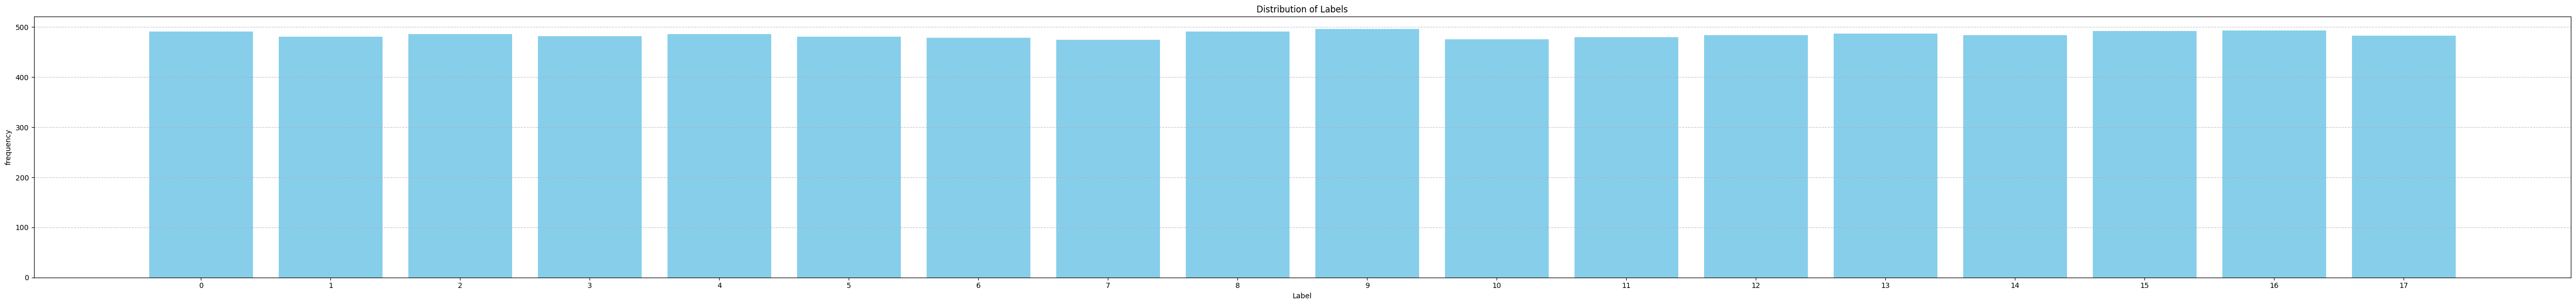

In [13]:
label_distribution(labels)

<font color = 'steelblue' size = 4> **As we can see, the dataset distribution of label images are balanced, they are around 450-500 images in each city for 18 cities** </font> 

In [14]:
rgb_images,grayscale_images = rgb_and_grayscale_images(scaled_images)

<font color = 'steelblue' size = 4> **Get random images and visualize the pixel values and their respective visualized images** </font> 

In [15]:
#function to get random samples of the images
def random_samples(labels, cities, num_images):
    random_indices = []
    for city in cities:
        label_indices = np.where(labels == city)[0]
        selected_indices = random.sample(list(label_indices), min(num_images, len(label_indices)))
        random_indices.extend([(city, idx) for idx in selected_indices])
    randoms = random.sample(random_indices, num_images)
    return randoms

#function to visualize the number of images you want to display
def visualize_images(images, cities_dict, idx,num_images):
    rows, cols = 1, num_images
    fig, subplots = plt.subplots(rows, cols, figsize=(12, 4))
    for i in range(cols):
        subplots[i].axis('off')
        image_for_city = images[idx[i][1]]
        city = cities_dict[idx[i][0]]
        subplots[i].set_title("City: " + city, fontsize=12)  # Corrected title concatenation
        subplots[i].imshow(image_for_city)
    plt.tight_layout()
    plt.show()


#function to plot the pixel values of the same images displayed from function above
def visualize_hist(images, cities_dict, idx, num_images):
    rows,cols = 1, num_images
    fig, subplots = plt.subplots(rows,cols,figsize=(12,4))
    for i in range(cols):
        image_for_city = images[idx[i][1]]
        city = cities_dict[idx[i][0]]
        subplots[i].set_title("City: " + city, fontsize=12)
        subplots[i].hist(image_for_city.flatten(),30,color = "skyblue",edgecolor='black',linewidth=0.3)
    plt.tight_layout()
    plt.show()

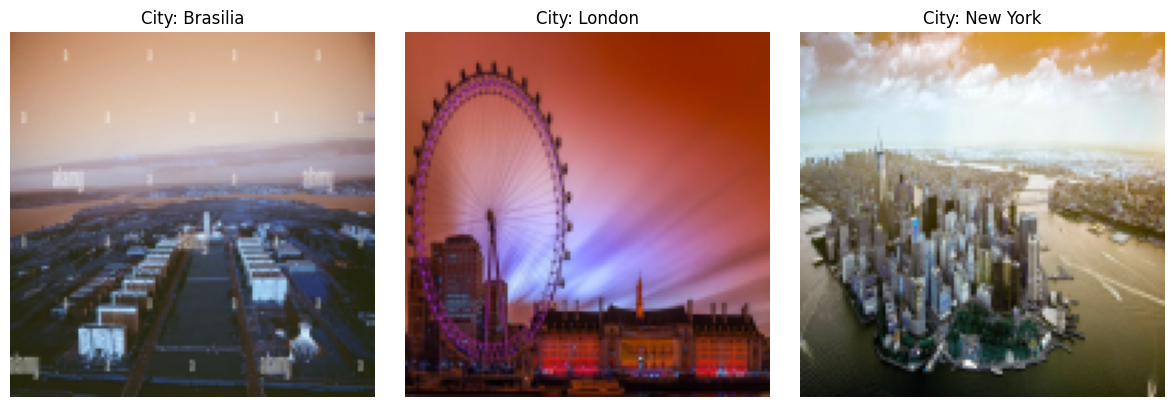

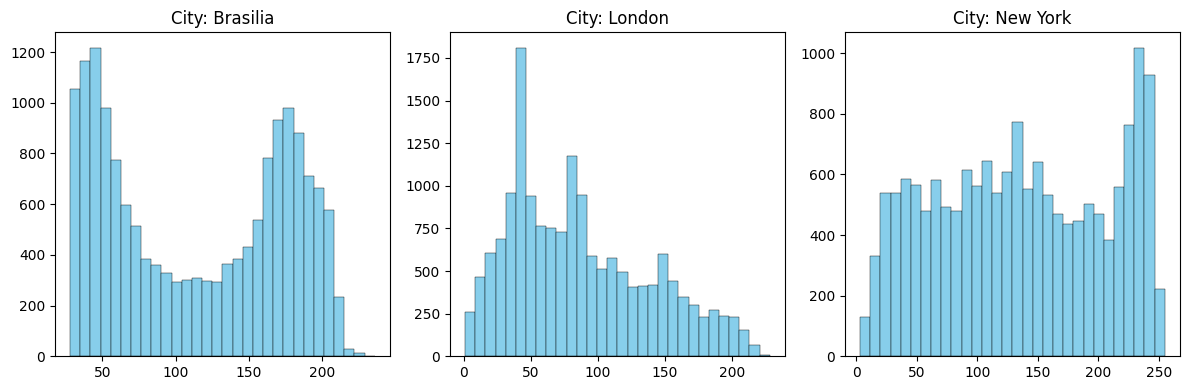

In [16]:
rnd_idx = random_samples(labels,cities,3)
visualize_images(rgb_images,cities_dict,rnd_idx,3)
visualize_hist(grayscale_images,cities_dict,rnd_idx,3)

<font color = 'steelblue' size = 4> **To improve dataset quality, we intentionally add noise to select images. Afterwards, we apply a median filter to eliminate any noise, ensuring our data is cleaner and more reliable for analysis.** </font> 

In [17]:
#function to randomly apply salt and pepper noise on the images
def apply_noise(images,amount=0.05,probability = 0.7):
    noisy_images = []
    for image in images:
        if random.random() > probability:
            noisy_image = util.random_noise(image, mode='s&p', amount=amount)
            noisy_images.append(noisy_image)
        else:
            noisy_images.append(image)

    return np.array(noisy_images)

#function to apply the median filter on all images to remove any chance of noisy images
def remove_noise(noisy_images,strength = 5):
    not_noisy_images = []
    for noisy_image in noisy_images:
        not_noisy_image = filters.median(noisy_image,footprint= strength)
        not_noisy_images.append(not_noisy_image)
    return np.array(not_noisy_images)

In [18]:
noisy_images = apply_noise(grayscale_images)
sample_footprint = np.array([[1,1, 1],
                             [1, 1, 1],
                             [1, 1, 1]])
not_noisy_images = remove_noise(noisy_images,sample_footprint)

<font color = 'steelblue' size = 4> **We then evaluate pairs of images: one with added noise and the other noise-free. We assess the need for noise reduction based on a predefined threshold, visualizes the differences, and retains the noise-free version if noise reduction is deemed unnecessary.** </font> 

In [24]:
#function to compare difference before and after median filter applied and clean the data and save new images into np array to ensure image cleansiness
def compare_image_difference(images, labels, countries, noisy_images, not_noisy_images, threshold=0.9):
    new_images = []
    image_pairs = []
    check_noise = [False,False]
    for noisy_image, not_noisy_image,original_image in zip(noisy_images, not_noisy_images,images):
        r2 = r2_score(noisy_image.flatten(), not_noisy_image.flatten())
        if r2 < threshold:
            new_images.append(not_noisy_image)
            if not check_noise[0]:
                difference_visual_1 = util.compare_images(noisy_image,not_noisy_image)
                image_pairs.append((original_image, noisy_image, not_noisy_image, difference_visual_1))
                check_noise[0] = True

        else:
            new_images.append(original_image)
            if not check_noise[1]:
                difference_visual_2 = util.compare_images(noisy_image,not_noisy_image)
                image_pairs.append((original_image, noisy_image, not_noisy_image, difference_visual_2))
                check_noise[1] = True

    fig, axes = plt.subplots(2, 4, figsize=(15, 8), gridspec_kw={'hspace': 0.3})

    for i, (original_image,noisy_image, not_noisy_image, difference_visual) in enumerate(image_pairs):
        mse = mean_squared_error(noisy_image, not_noisy_image)
        r2 = r2_score(noisy_image.flatten(), not_noisy_image.flatten())
        axes[i, 0].imshow(noisy_image, cmap='gray')
        axes[i, 0].set_title(f'Possible Noisy Image {i+1}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(not_noisy_image, cmap='gray')
        axes[i, 1].set_title(f'Noise Removed Image {i+1}')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(difference_visual, cmap='viridis')
        axes[i, 2].set_title(f'Difference {i+1}\nMSE: {mse:.4f}\nR2: {r2:.4f}')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(original_image, cmap='gray')
        axes[i, 3].set_title(f'Original {i+1}')
        axes[i, 3].axis('off')
    plt.show()

    return np.array(new_images)

<font color = 'steelblue' size = 4> **We divide the grayscale images by 255 so that we have the ranges in between [0,1], and the reason why is to keep the values small for CNN because it keeps the activations smaller than if [0,255] was used** </font> 

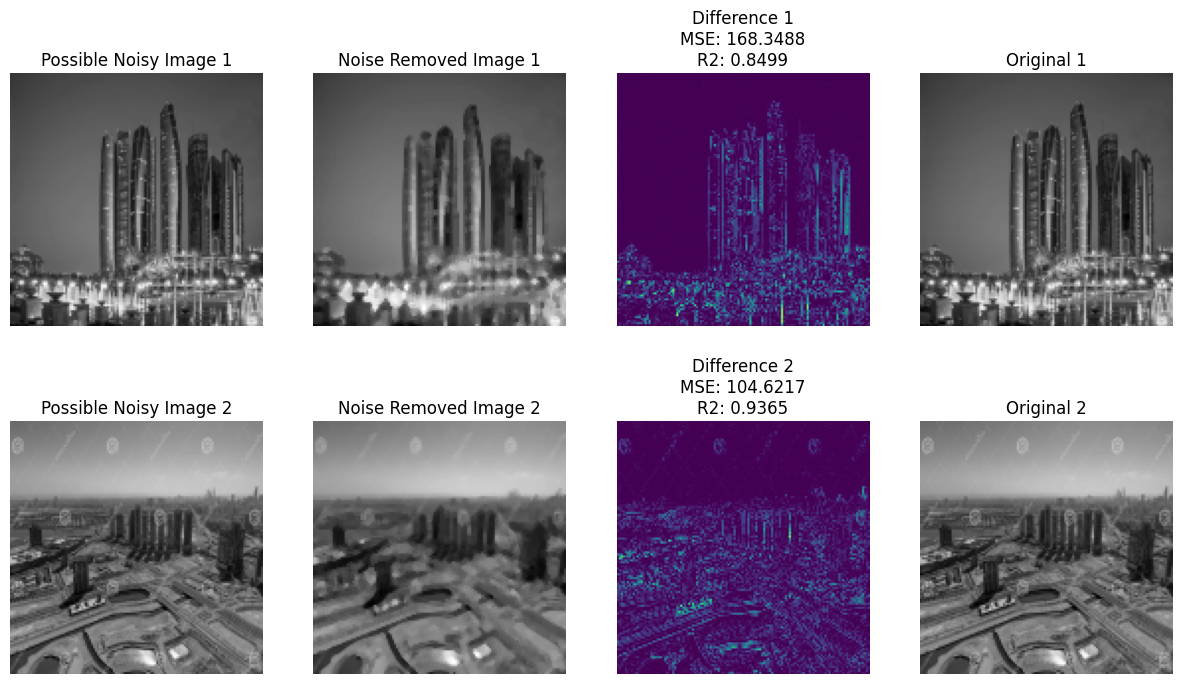

((8727, 128, 128), (8727,))

In [27]:
new_grayscale_images = compare_image_difference(grayscale_images,labels,cities,noisy_images,not_noisy_images)
new_grayscale_images /= 255

new_grayscale_images.shape, labels.shape

<font color = 'steelblue' size = 4> **The noise-free images consistently achieve an R-squared score above 0.9 after applying the median filter, indicating minimal discrepancy between the original and filtered versions. Conversely, the noisy images exhibit higher differences post-noise removal. Despite this, the median filter effectively reduces noise in the images, making them suitable for use. Hence, we opt to utilize the median-filtered images.** </font> 

***
<font color = 'steelblue' size = 4> **The process of loading the images into memory, resizing, applying noise takes up a lot of memory and time. To save this time, we can stored the processed images in a shelve object, and reload it when needed. The code below does exactly that** </font> 

In [3]:
import shelve

# save pre-computed cleaned data to save computation time
def save_cleaned_data(filename):

    data = shelve.open(filename)
    data['gray'] = new_grayscale_images
    data['color'] = rgb_images
    data['labels'] = labels
    data['num_classes'] = num_classes
    data.close()

def load_cleaned_data(filename):

    data = shelve.open(filename)
    new_grayscale_images = data['gray']
    rgb_images = data['color'] 
    labels = data['labels']
    num_classes = data['num_classes']
    data.close()
    return new_grayscale_images, rgb_images, labels, num_classes


## 2.4 Feature Engineering 

In [9]:
new_grayscale_images, rgb_images, labels, num_classes = load_cleaned_data("small")

In [12]:
num_imgs = new_grayscale_images.shape[0]

<font color = 'steelblue'> <b> Get the histogram values of the greyscale images </b> </font>

In [10]:
def get_histogram_values(img, nbins=30):

    hist, bins = np.histogram(img, nbins, (0., 1.))

    return hist

In [13]:

hist_features = np.zeros((num_imgs, 30))

for idx, img in tqdm(enumerate(new_grayscale_images)):
    hist_features[idx] = get_histogram_values(img, nbins=30)


8727it [00:01, 4718.17it/s]


<font color = 'steelblue'> <b> Get the Histogram of Gradient features in the images </b> </font>

In [14]:
from skimage.feature import hog

hogs = [hog(image, orientations=8, pixels_per_cell = (8, 8), cells_per_block = (3, 3), feature_vector=True) for image in tqdm(new_grayscale_images)]
hog_features = np.array(hogs)

100%|██████████| 8727/8727 [00:44<00:00, 197.67it/s]


<font color = 'steelblue'> <b>Get the SIFT features of the images</b> </font>

In [15]:
def get_sift_features(img, nfeatures, max_kp=30, only_length=False):

    sift = cv2.SIFT.create(nfeatures=nfeatures, contrastThreshold=0.004)

    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    kp_tuple, desc_array = sift.detectAndCompute(img, None)

    # if only length must be found then return and ignore the rest of the function
    if only_length:
        return len(kp_tuple)

    if len(kp_tuple) >= max_kp:
        # only use first max_kp keypoints
        kp_tuple = kp_tuple[:max_kp]
        desc_array = desc_array[:max_kp]
    else:
        # fill until max_kp keypoints
        kp_tuple += kp_tuple[-1:] * (max_kp - len(kp_tuple))

        num_repeats = np.ones((desc_array.shape[0], ), dtype=np.int64)
        num_repeats[-1] += max_kp - desc_array.shape[0]

        desc_array = np.repeat(desc_array, num_repeats, axis=0)

    result = []
    for kp, desc in zip(kp_tuple, desc_array):
        result.append(np.concatenate( (np.array(kp.pt), desc) ))

    return np.array(result).flatten()

<font color = 'steelblue'> <b> We find the lengths of the keypoints and display them in a histogram. We then take the median length of keypoints and use that as the number of keypoints. </b></font>

In [22]:
num_imgs = new_grayscale_images.shape[0]

# create array to store the length of the keypoints
kp_lens = np.zeros((num_imgs, ))

# get the lengths so we know how many keypoints to use
for idx, img in tqdm(enumerate(new_grayscale_images)):
    kp_lens[idx] = get_sift_features(img, 50, only_length=True)

8727it [00:46, 188.77it/s]


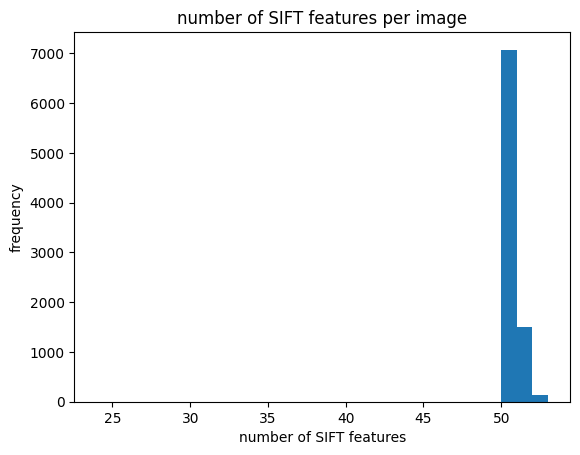

In [23]:
# plot the distribution of keypoints lengths
plt.hist(kp_lens, bins=int(np.max(kp_lens) - np.min(kp_lens)), 
         range=(float(np.min(kp_lens)), float(np.max(kp_lens))))
plt.title("number of SIFT features per image")
plt.xlabel("number of SIFT features")
plt.ylabel("frequency")
plt.show()

In [24]:
# use the median value of the lengths as the number of keypoints
num_kp = int(np.median(kp_lens))

print(f'number of keypoints used: {num_kp}')

# create np array to store keypoints
sift_features = np.zeros((num_imgs, 130 * num_kp))

for idx, img in tqdm(enumerate(new_grayscale_images)):
    sift_features[idx] = get_sift_features(img, 50, max_kp=num_kp)
    
sift_features.shape

number of keypoints used: 50


8727it [00:45, 192.64it/s]


(8727, 6500)

<font color = 'steelblue'> <b> Apply the Sobel filter to the greyscale images, flatten and store them</b> </font>

In [27]:
from skimage.filters import sobel

sobel_features = np.array([sobel(image) for image in new_grayscale_images])

# Flatten the sobel
sobel_features_flat = sobel_features.reshape(sobel_features.shape[0], 128*128)

<font color = 'steelblue'> <b> Apply the Canny filter to the greyscale images, flatten and store them</b> </font>

In [28]:
from skimage.feature import canny

canny_features = np.array([canny(image) for image in new_grayscale_images])

# Flatten the canny
canny_features_flat = canny_features.reshape(canny_features.shape[0], 128*128)

# 3 Model Training

We will go through three iterations of models to determine the best model to use for the given task

In [11]:
input_shape = (img_shape[0], img_shape[1], 1)

CNN_model = Sequential([Input(shape=input_shape),
                        Conv2D(64, kernel_size=(7, 7), activation='leaky_relu'),
                        Conv2D(64, kernel_size=(7, 7), activation='leaky_relu'),
                        Dropout(0.25),
                        MaxPool2D(),
                        Conv2D(32, kernel_size=(7, 7), activation='leaky_relu'),
                        Conv2D(32, kernel_size=(7, 7), activation='leaky_relu'),
                        Dropout(0.25),
                        MaxPool2D(),
                        Conv2D(32, kernel_size=(5, 5), activation='leaky_relu'),
                        Conv2D(32, kernel_size=(5, 5), activation='leaky_relu'),
                        MaxPool2D(),
                        Dropout(0.25),
                        Flatten(),
                        Dense(2048, activation='leaky_relu'),
                        Dense(1024, activation='leaky_relu'),
                        Dropout(0.3),
                        Dense(512, activation='leaky_relu'),
                        Dense(256, activation='leaky_relu'),
                        Dropout(0.3),
                        Dense(128, activation='leaky_relu'),
                        Dense(num_classes, activation='softmax')
                        ])

CNN_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 122, 122, 64)   │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 116, 116, 64)   │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 116, 116, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │       100,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 32)     │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 19, 19, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 15, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     3,213,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,408,658 (24.45 MB)

 Trainable params: 6,408,658 (24.45 MB)

 Non-trainable params: 0 (0.00 B)

### Training the CNN

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(new_grayscale_images, labels, test_size=0.05, shuffle=True)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8290, 128, 128), (437, 128, 128), (8290,), (437,))

In [14]:
num_validation = int(0.3 * X_test.shape[0])
batches = 128
num_epochs = 20

training = CNN_model.fit(X_train, Y_train,
                         batch_size=batches,
                         epochs=num_epochs,
                         validation_data=(X_test[:num_validation],
                                          Y_test[:num_validation]))

score = CNN_model.evaluate(X_test, Y_test, verbose=0)

print('Test score: ', score[0])
print('Test accuracy: ', score[1])

Epoch 1/20


2024-04-25 22:42:41.275386: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[128,64,116,116]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,122,122]{3,2,1,0}, f32[64,64,7,7]{3,2,1,0}, f32[64]{0}), window={size=7x7}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-25 22:42:41.834652: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.559403292s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[128,64,116,116]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,64,122,122]{3,2,1,0}, f32[64,64,7,7]{3,2,1,0}, f32[64]{0}), window={size=7x7}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2

64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.0551 - loss: 2.9106

2024-04-25 22:44:20.742569: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[98,64,116,116]{3,2,1,0}, u8[0]{0}) custom-call(f32[98,64,122,122]{3,2,1,0}, f32[64,64,7,7]{3,2,1,0}, f32[64]{0}), window={size=7x7}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-25 22:44:20.975532: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.23308249s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[98,64,116,116]{3,2,1,0}, u8[0]{0}) custom-call(f32[98,64,122,122]{3,2,1,0}, f32[64,64,7,7]{3,2,1,0}, f32[64]{0}), window={size=7x7}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-0

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0551 - loss: 2.9105   

W0000 00:00:1714085117.685337     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


65/65 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.0551 - loss: 2.9104 - val_accuracy: 0.0611 - val_loss: 2.8884
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 337ms/step - accuracy: 0.0584 - loss: 2.8914 - val_accuracy: 0.0534 - val_loss: 2.8957
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 338ms/step - accuracy: 0.0569 - loss: 2.8902 - val_accuracy: 0.0382 - val_loss: 2.8989
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 339ms/step - accuracy: 0.0554 - loss: 2.8911 - val_accuracy: 0.0611 - val_loss: 2.8917
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 341ms/step - accuracy: 0.0595 - loss: 40.8005 - val_accuracy: 0.0534 - val_loss: 13710.9287
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 341ms/step - accuracy: 0.0567 - loss: 871.2939 - val_accuracy: 0.0534 - val_loss: 634.2735
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 341ms/step - accuracy: 0.0584 - loss: 307.0118 - val_accuracy: 0.0382 - val_loss: 176.3484
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 342ms/step - accuracy: 0.0530 - loss: 6.5303 - val_accu

W0000 00:00:1714085554.320320     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test score:  21.212190628051758
Test accuracy:  0.06178489699959755


W0000 00:00:1714085562.773560     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### Visualising the CNN features

In [15]:
def show_learning_curves(learning_evolution, title=''):

    # list all data stored in the learning_evolution object
    print('Stored information:', [h for h in learning_evolution.history.keys()])

    # show evolution of accuracy
    plt.plot(learning_evolution.history['accuracy'])

    # show evolution of cross-validated accuracy
    if 'val_accuracy' in learning_evolution.history:
        plt.plot(learning_evolution.history['val_accuracy'])

    plt.title(title + 'Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # show evolution of loss
    plt.plot(learning_evolution.history['loss'])
    
     # show evolution of cross-validated loss
    if 'val_accuracy' in learning_evolution.history:
        plt.plot(learning_evolution.history['val_loss'])

    plt.title(title + 'Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Stored information: ['accuracy', 'loss', 'val_accuracy', 'val_loss']


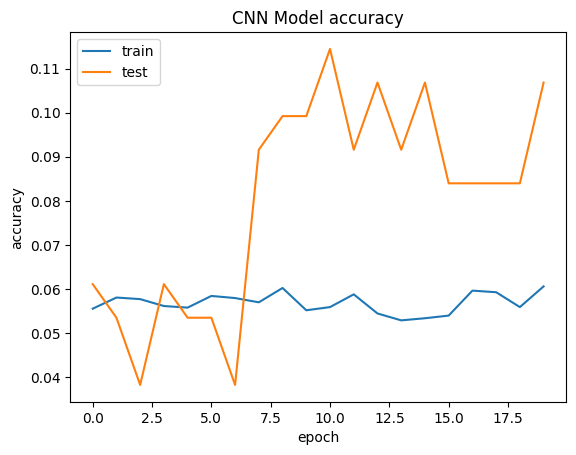

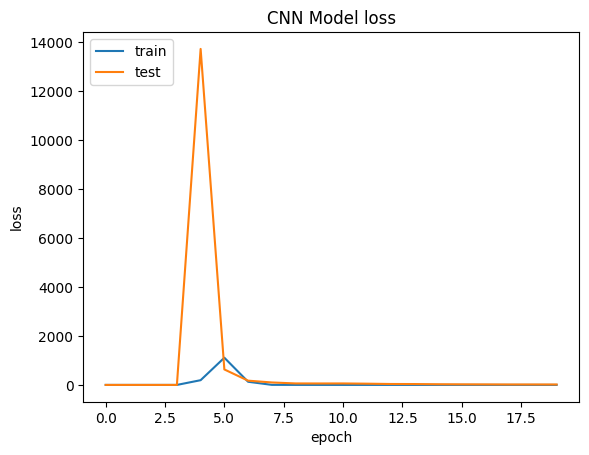

In [16]:
show_learning_curves(training, 'CNN ')

In [17]:
from keras.models import Model

def display_activation(activations, activation_index, ncols=5, size=(12, 12), reshape=None):

    activation = activations[activation_index]

    print('Shape of layer: ', activation.shape)

    if len(activation.shape) > 2:
        total_fmaps = activation.shape[-1] # the last axis of the array
        nrows = int(np.ceil(total_fmaps / ncols))
    else:
        total_fmaps = 1
        nrows,ncols = (1,1)

    feature_map=0

    if (ncols, nrows) == (1,1):
        plt.yticks([], [])
        plt.xticks(fontsize=6)
        if reshape == None:
            plt.imshow(activation[0].reshape(-1,1).T)
        else:
            plt.imshow(activation[0].reshape(reshape).T)
        plt.show()
        return

    fig = plt.figure(figsize=size)
    fig.subplots_adjust(hspace=0.23, wspace=0.22)

    for row in range(nrows):
        for col in range(ncols):
            subplot = fig.add_subplot(nrows, ncols, feature_map+1)
            #subplot[row][col].imshow(activation[0, :, :, feature_map],
            #                         cmap='gray')
            #subplot[row][col].tick_params(labelsize = 3)
            subplot.imshow(activation[0, :, :, feature_map])# cmap='gray')
            subplot.tick_params(labelsize = 3)

            feature_map += 1
            if feature_map == total_fmaps:
                plt.show()
                return

In [18]:
layer_outputs = [layer.output for layer in CNN_model.layers]

layer_names = [layer.name.split('_')[0] for layer in CNN_model.layers]

activation_model = Model(inputs=CNN_model.layers[0].input, outputs=layer_outputs)

sample_idx = 1324
img_sample = new_grayscale_images[sample_idx].reshape((1, *input_shape))

activations = activation_model.predict(img_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


'label: 2'

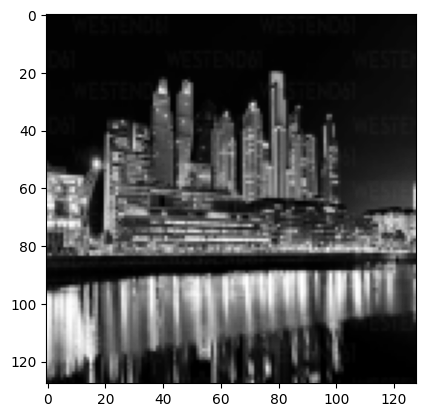

In [19]:
plt.imshow(new_grayscale_images[sample_idx], cmap='gray')
f'label: {labels[sample_idx]}'

Type of layer:  conv2d
Shape of layer:  (1, 122, 122, 64)


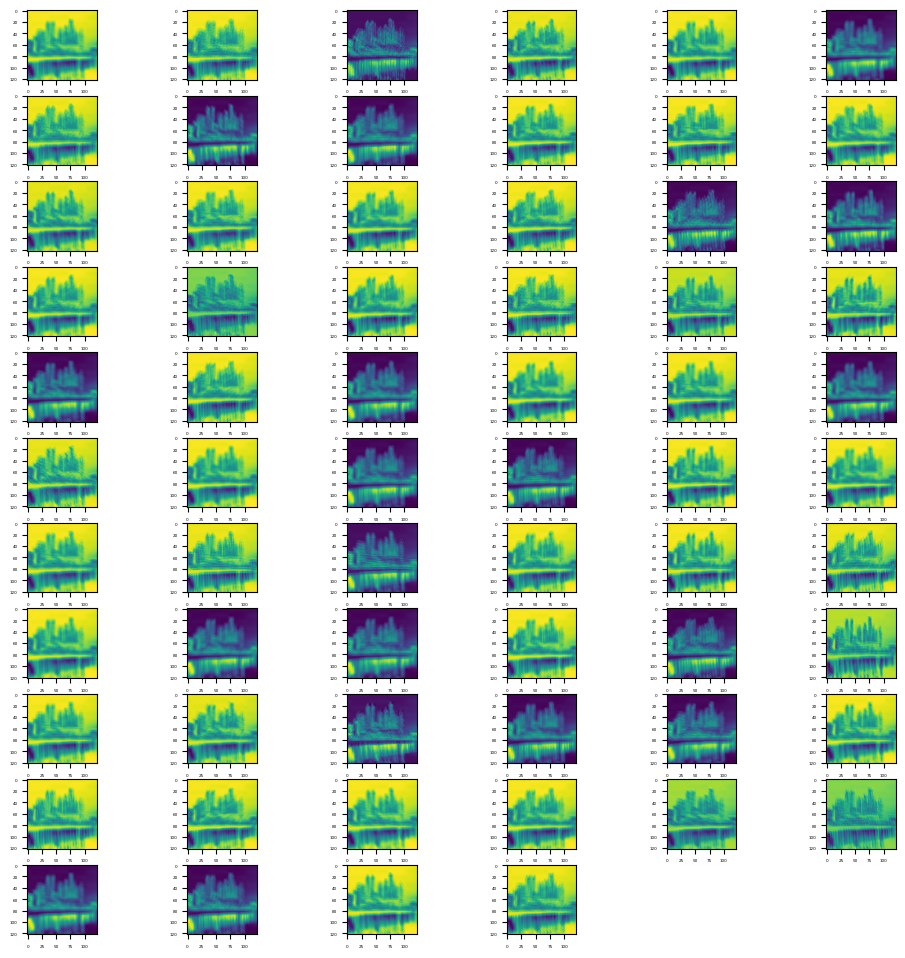

Type of layer:  conv2d
Shape of layer:  (1, 116, 116, 64)


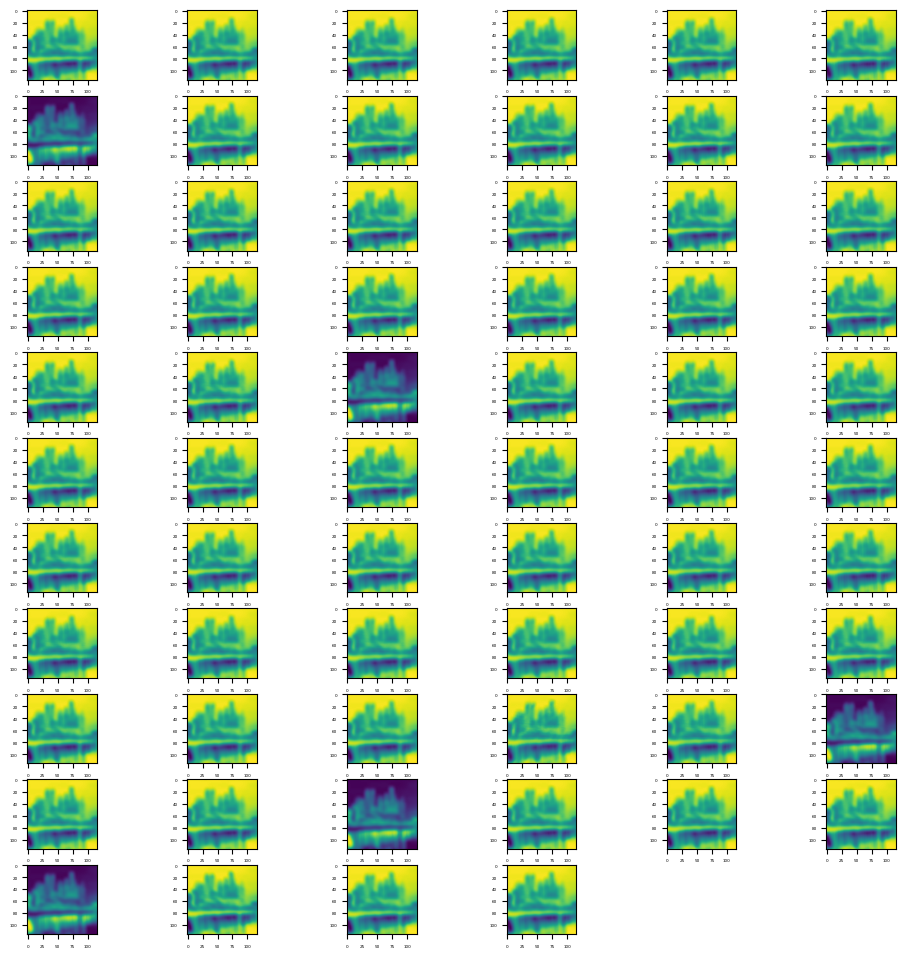

Type of layer:  dropout
Type of layer:  max
Type of layer:  conv2d
Shape of layer:  (1, 52, 52, 32)


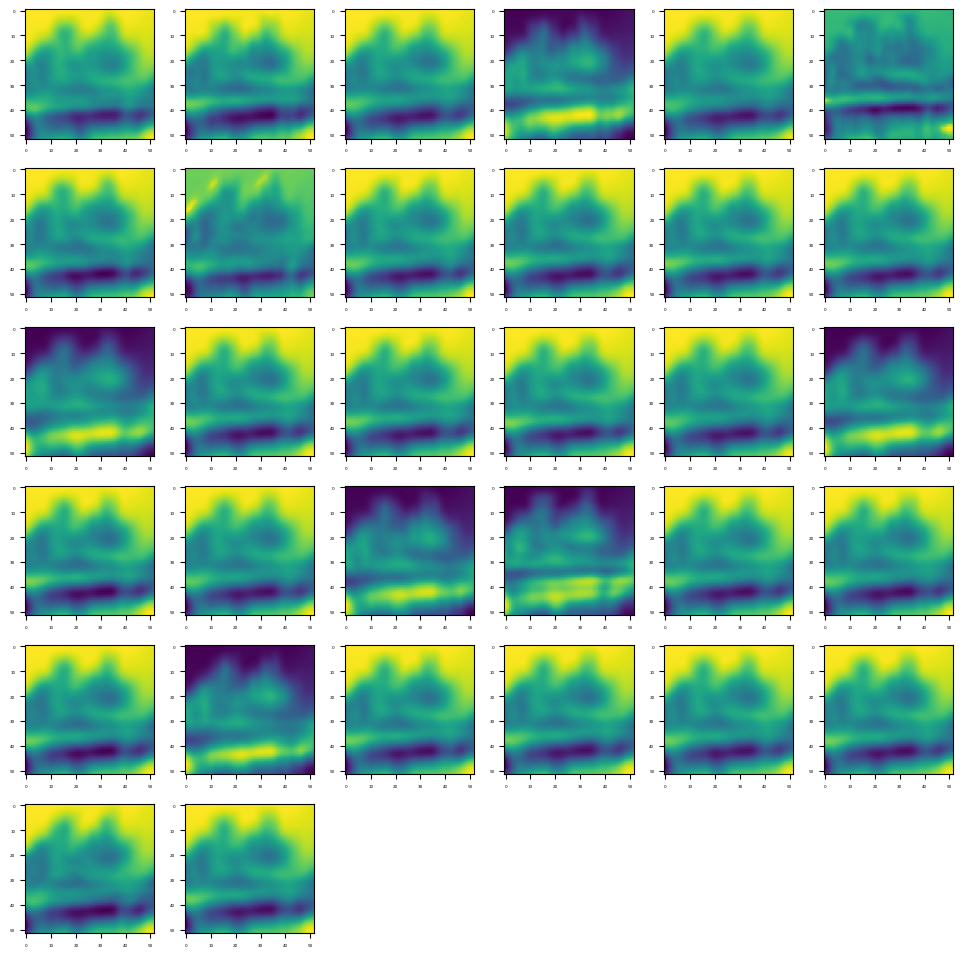

Type of layer:  conv2d
Shape of layer:  (1, 46, 46, 32)


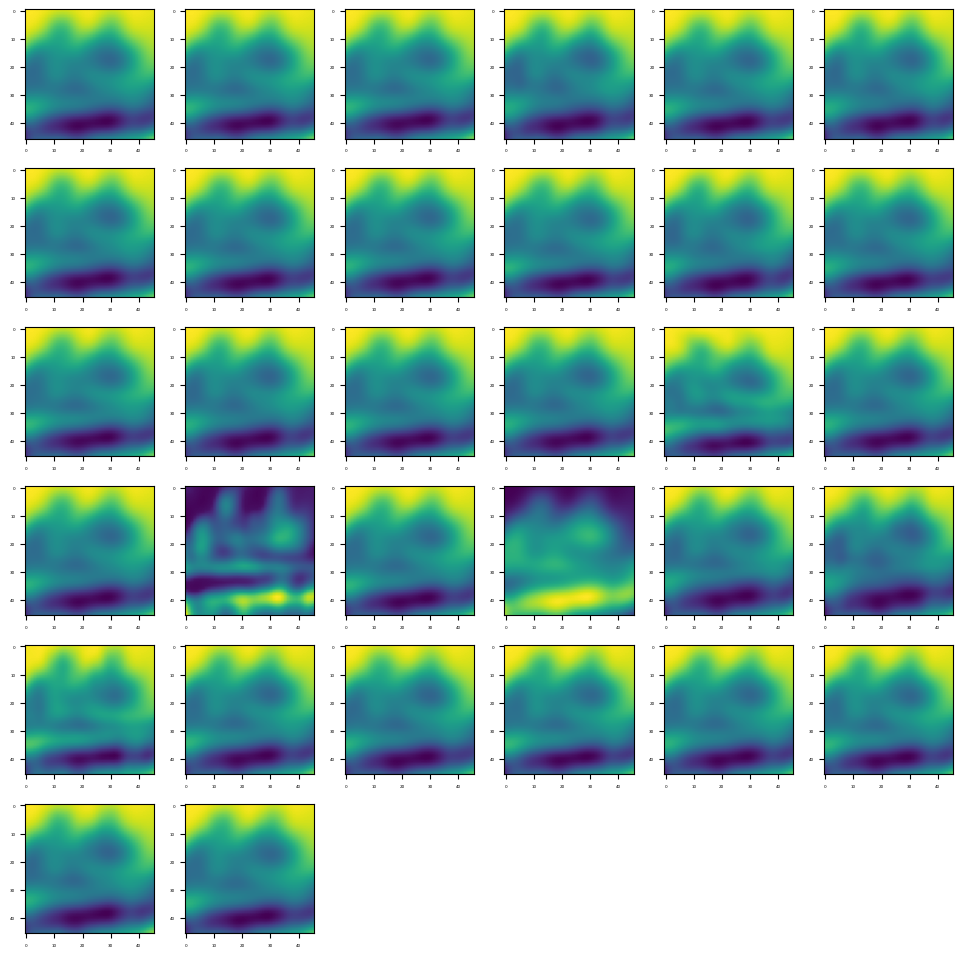

Type of layer:  dropout
Type of layer:  max
Type of layer:  conv2d
Shape of layer:  (1, 19, 19, 32)


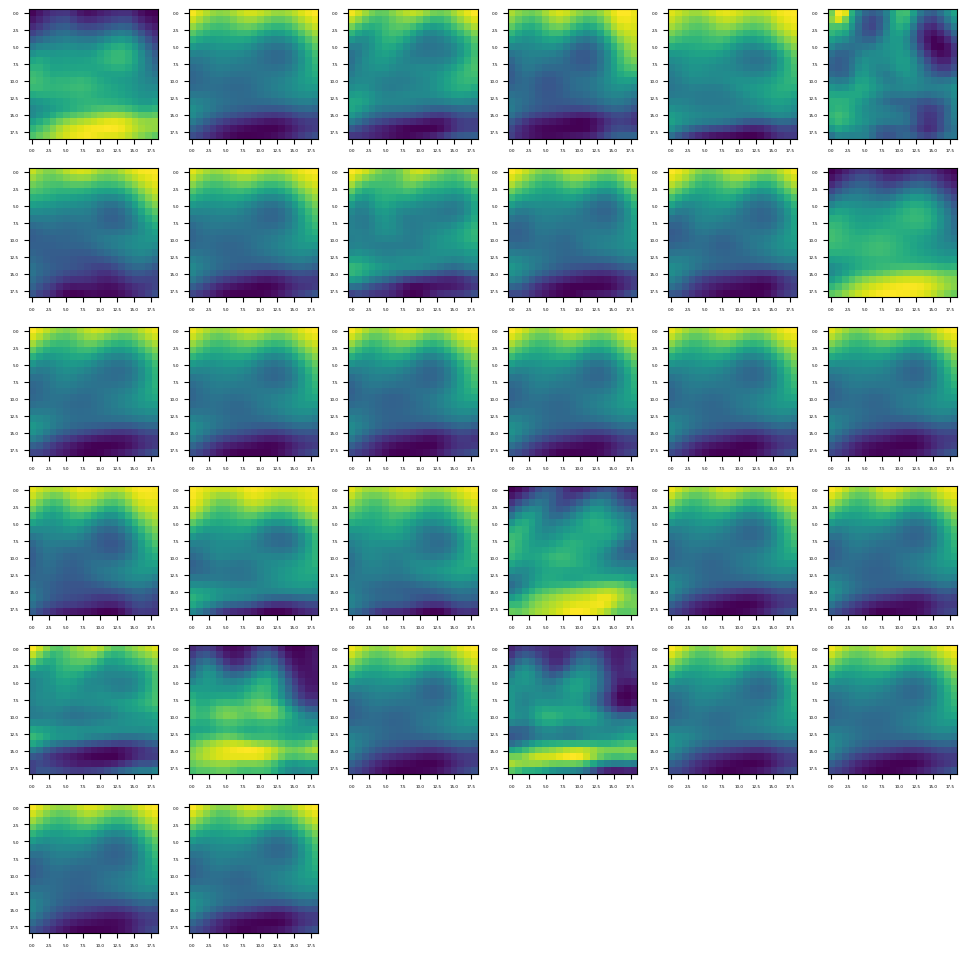

Type of layer:  conv2d
Shape of layer:  (1, 15, 15, 32)


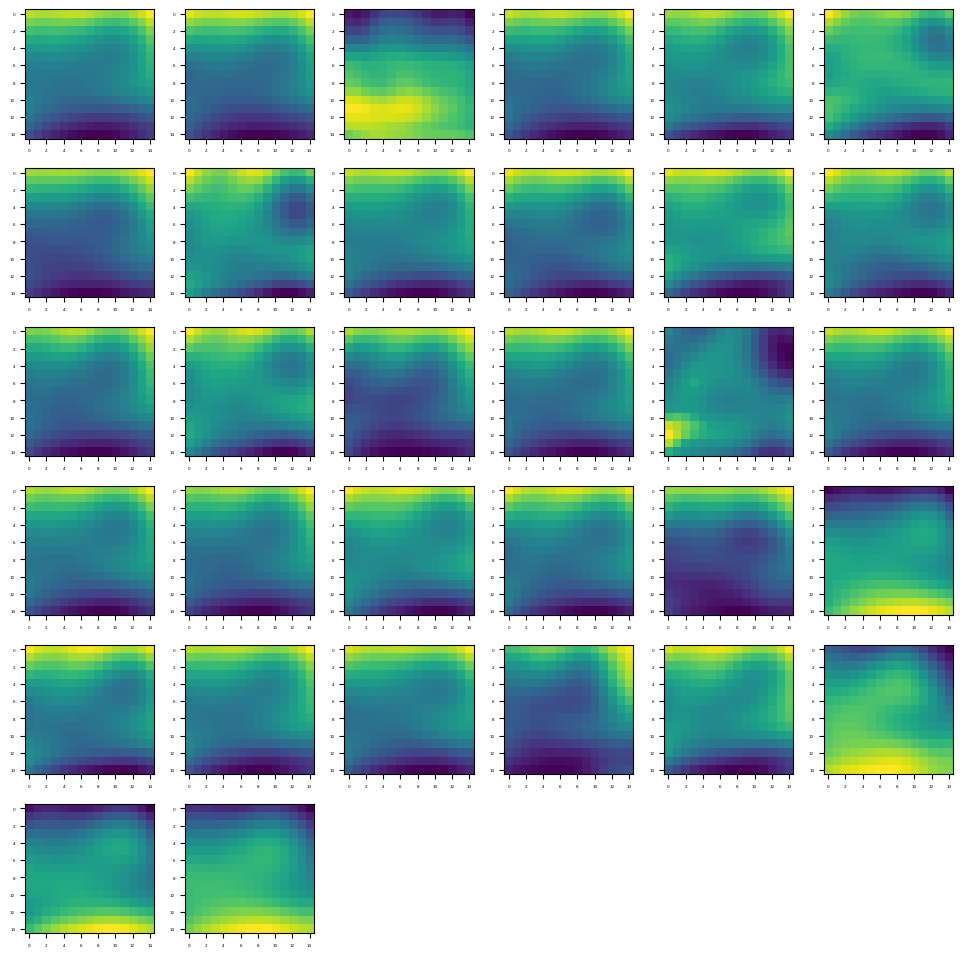

Type of layer:  max
Type of layer:  dropout
Type of layer:  flatten
Type of layer:  dense
Type of layer:  dense
Type of layer:  dropout
Type of layer:  dense
Type of layer:  dense
Type of layer:  dropout
Type of layer:  dense
Type of layer:  dense


In [20]:
for i in range(len(layer_names)):
    print('Type of layer: ', layer_names[i])
    if layer_names[i] == 'conv2d':
        display_activation(activations, i, 6)

Shape of layer:  (1, 2048)


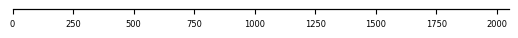

Shape of layer:  (1, 1024)


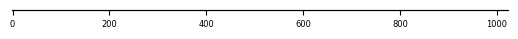

Shape of layer:  (1, 512)


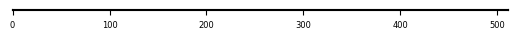

Shape of layer:  (1, 256)


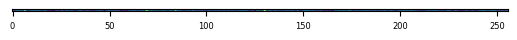

Shape of layer:  (1, 128)


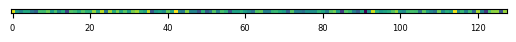

Shape of layer:  (1, 18)


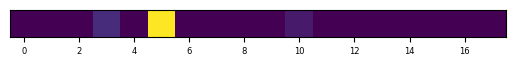

In [21]:
for i in range(len(layer_names)):
    if layer_names[i] == 'dense':
        display_activation(activations, i, 1)

In [22]:
np.argmax(activations[-1])

5